## Initial imports

In [1]:
from scm.plams import *
import os
import numpy as np
import matplotlib.pyplot as plt

init()

PLAMS working folder: /home/hellstrom/adfhome/scripting/scm/plams/doc/source/examples/AMSPlumedMD/plams_workdir


## Initial system

Define a Molecule from xyz coordinates and show the molecule.

* O(3) is the right-most O atom
* H(6) is the left-most H atom

In [2]:
def get_molecule():
    job = AMSJob.from_input('''
    system
      Atoms
                  O      -0.1009275285       1.5113007791      -0.4061554537 
                  C       0.0189044656       0.3835929386       0.1570043855
                  O       1.2796450751      -0.2325516597       0.3936038789
                  O      -1.0798994361      -0.4640886294       0.4005134306
                  H       1.7530114719      -0.6822230417      -0.3461237499
                  H      -1.8707340481      -0.5160303870      -0.1988424913
      End
    End
    ''')
    return job.molecule['']

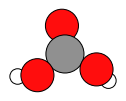

In [3]:
mol = get_molecule()

try: plot_molecule(mol) # plot Molecule in Jupyter Notebook in AMS2023+
except NameError: pass  # ignore errors in AMS2022-

## Calculation settings

In [4]:
current_O3H6 = mol[3].distance_to(mol[6]) 
target_O3H6 = 0.95

print(f"Scanning bond O3-H6 from {current_O3H6:.3f} to {target_O3H6:.3f} angstrom (this will form a water molecule)")

current_O1C2 = mol[1].distance_to(mol[2]) 

print(f"Restraining bond O1-C2 at {current_O1C2:.3f} angstrom")

Scanning bond O3-H6 from 3.218 to 0.950 angstrom (this will form a water molecule)
Restraining bond O1-C2 at 1.266 angstrom


In [5]:
nsteps = 10000     # number of MD steps
kappa = 500000.0   # strength of Plumed MovingRestraint

s = Settings()
# run in serial
s.runscript.nproc = 1
s.runscript.preamble_lines = ['export OMP_NUM_THREADS=1']

# engine settings
s.input.ReaxFF.ForceField = 'CHO.ff'   # If you have ReaxFF license
#s.input.MLPotential.Model = 'M3GNet-UP-2022'   # if you have ML potential license and M3Gnet installed
#s.input.dftb  # if you have a DFTB license

# MD settings
s.input.ams.Task = 'MolecularDynamics'
s.input.ams.MolecularDynamics.NSteps = nsteps
s.input.ams.MolecularDynamics.Trajectory.SamplingFreq = 100
s.input.ams.MolecularDynamics.InitialVelocities.Temperature = 200
s.input.ams.MolecularDynamics.Thermostat.Temperature = 500
s.input.ams.MolecularDynamics.Thermostat.Tau = 100
s.input.ams.MolecularDynamics.Thermostat.Type = 'Berendsen'

# use an AMS restraint for one of the C-O bond lengths
s.input.ams.Restraints.Distance = []
s.input.ams.Restraints.Distance.append(f'1 2 {current_O1C2} 1.0')

# use an AMS EngineAddon WallPotential to keep the molecules within a sphere of radius 4 angstrom
s.input.ams.EngineAddons.WallPotential.Enabled = 'Yes'
s.input.ams.EngineAddons.WallPotential.Radius = 4.0

# Plumed input, note that distances are given in nanometer so multiply by 0.1
s.input.ams.MolecularDynamics.Plumed.Input = f'''
    DISTANCE ATOMS=3,6 LABEL=d36
    MOVINGRESTRAINT ARG=d36 STEP0=1 AT0={current_O3H6*0.1} KAPPA0={kappa} STEP1={nsteps} AT1={target_O3H6*0.1}
    PRINT ARG=d36 FILE=colvar-d36.dat STRIDE=20
    End'''

job = AMSJob(settings=s, molecule=mol, name='dissociating-carbonic-acid')
print(job.get_input())

EngineAddons
  WallPotential
    Enabled Yes
    Radius 4.0
  End
End

MolecularDynamics
  InitialVelocities
    Temperature 200
  End
  NSteps 10000
  Plumed
    Input 
    DISTANCE ATOMS=3,6 LABEL=d36
    MOVINGRESTRAINT ARG=d36 STEP0=1 AT0=0.32181114819547796 KAPPA0=500000.0 STEP1=10000 AT1=0.095
    PRINT ARG=d36 FILE=colvar-d36.dat STRIDE=20
    End
  End
  Thermostat
    Tau 100
    Temperature 500
    Type Berendsen
  End
  Trajectory
    SamplingFreq 100
  End
End

Restraints
  Distance 1 2 1.2661886450379047 1.0
End

Task MolecularDynamics

system
  Atoms
              O      -0.1009275285       1.5113007791      -0.4061554537 
              C       0.0189044656       0.3835929386       0.1570043855 
              O       1.2796450751      -0.2325516597       0.3936038789 
              O      -1.0798994361      -0.4640886294       0.4005134306 
              H       1.7530114719      -0.6822230417      -0.3461237499 
              H      -1.8707340481      -0.5160303870      

## Run the job

In [6]:
job.run();

[02.02|11:29:02] JOB dissociating-carbonic-acid STARTED
[02.02|11:29:03] JOB dissociating-carbonic-acid RUNNING
[02.02|11:29:06] JOB dissociating-carbonic-acid FINISHED
[02.02|11:29:06] JOB dissociating-carbonic-acid SUCCESSFUL


## Analyze the trajectory

Extract the O3H6 distances at each stored frame, and plot some of the molecules

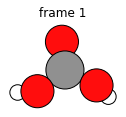

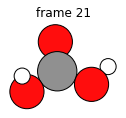

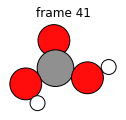

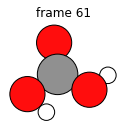

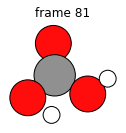

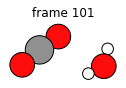

In [7]:
trajectory = Trajectory(job.results.rkfpath())

O3H6_distances = []
for i, mol in enumerate(trajectory, 1):
    O3H6_distances.append(mol[3].distance_to(mol[6]))
    if i % 20 == 1:
        try:
            plot_molecule(mol) # mol is a PLAMS Molecule
            plt.title(f"frame {i}")
            plt.show()
        except NameError:
            pass

The above pictures show how the H(6) approaches the O(3). At the end, the carbonic acid molecule has dissociated into CO2 and H2O.

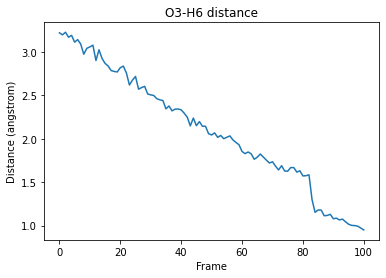

In [8]:
plt.plot(O3H6_distances)
plt.ylabel("Distance (angstrom)")
plt.xlabel("Frame")
plt.title("O3-H6 distance")
plt.show()

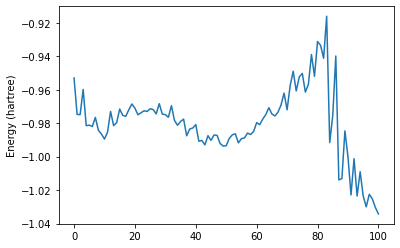

In [9]:
energies = job.results.get_history_property('Energy')
plt.plot(energies)
plt.ylabel("Energy (hartree)")
plt.show()

## A transition state search

PLAMS makes it easy to extract any frame from an MD trajectory. As an example, let's use highest-energy frame as an initial structure for a transition state search with the ADF DFT engine.

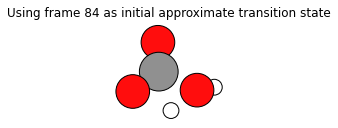

In [14]:
index = np.argmax(energies) + 1
approximate_ts_molecule = job.results.get_history_molecule(index)

try: 
    plot_molecule(approximate_ts_molecule)
    plt.title(f"Using frame {index} as initial approximate transition state")
except NameError: pass

In [11]:
ts_s = Settings()
ts_s.input.ams.task = 'TransitionStateSearch'
ts_s.input.ams.GeometryOptimization.InitialHessian.Type = 'Calculate'
ts_s.input.ams.Properties.NormalModes = 'Yes'
ts_s.input.adf.xc.gga = 'PBE'
ts_job = AMSJob(settings=ts_s, molecule=approximate_ts_molecule, name='ts-search')
ts_job.run();

[02.02|11:29:07] JOB ts-search STARTED
[02.02|11:29:07] JOB ts-search RUNNING
[02.02|11:29:56] JOB ts-search FINISHED
[02.02|11:29:56] JOB ts-search SUCCESSFUL


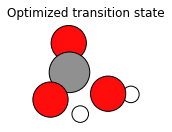

In [15]:
try:
    plot_molecule(ts_job.results.get_main_molecule())
    plt.title("Optimized transition state")
except NameError:
    pass

In [13]:
print("Frequencies (at a TS there should be 1 imaginary [given as negative])")

for f in ts_job.results.get_frequencies():
    print(f'{f:.3f} cm^-1')

Frequencies (at a TS there should be 1 imaginary [given as negative])
-1422.038 cm^-1
314.722 cm^-1
365.431 cm^-1
545.714 cm^-1
702.591 cm^-1
744.407 cm^-1
877.082 cm^-1
1080.398 cm^-1
1119.906 cm^-1
1759.415 cm^-1
2064.579 cm^-1
3470.480 cm^-1
